# 4조 Project: Toyota Corolla 중고차 가격 예측

### 노범용, 유정오, 양영규, 한상훈

In [203]:
from patsy import dmatrix
import scipy as sp

import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import sklearn.model_selection

## 1. 분석대상 Data 가져오기

In [204]:
test = pd.read_csv("test.csv")
df = pd.read_csv("train.csv")
df = df.set_index('Id')

In [205]:
#test = pd.read_csv("test.csv") # 회귀모델 결정 후 예측의 대상이 되는 data 
#df = pd.read_csv("train.csv") # train dataset (cross validation을 위해 나눌 것. 비율은? )
#var_desc = pd.read_excel("data_description.xls") # 독립변수에 대한 간단한 설명
#df = df.set_index('Id')

## 2. 데이터 살펴보기

In [206]:
df.tail(2)

,Model,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,Fuel_Type,HP,Met_Color,Color,...,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Parking_Assistant,Tow_Bar
Id,,,,,,,,,,,,,,,,,,,,,
1441,TOYOTA Corolla 1.3 16V HATCHB LINEA TERRA 2/3-...,7250,70,11,1998,16916,Petrol,86,1,Grey,...,0,0,0,0,0,1,0,0,0,0
1442,TOYOTA Corolla 1.6 LB LINEA TERRA 4/5-Doors,6950,76,5,1998,1,Petrol,110,0,Green,...,0,1,0,0,0,0,0,0,0,0


In [207]:
# 확인해보니 데이터셋에 NaN 값은 없음. Model, Fuel_Type, Color은 문자열값
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1019 entries, 1 to 1442
Data columns (total 38 columns):
Model                1019 non-null object
Price                1019 non-null int64
Age_08_04            1019 non-null int64
Mfg_Month            1019 non-null int64
Mfg_Year             1019 non-null int64
KM                   1019 non-null int64
Fuel_Type            1019 non-null object
HP                   1019 non-null int64
Met_Color            1019 non-null int64
Color                1019 non-null object
Automatic            1019 non-null int64
CC                   1019 non-null int64
Doors                1019 non-null int64
Cylinders            1019 non-null int64
Gears                1019 non-null int64
Quarterly_Tax        1019 non-null int64
Weight               1019 non-null int64
Mfr_Guarantee        1019 non-null int64
BOVAG_Guarantee      1019 non-null int64
Guarantee_Period     1019 non-null int64
ABS                  1019 non-null int64
Airbag_1             1019 non

In [208]:
#기술통계량 확인
print(df.describe())

              Price    Age_08_04    Mfg_Month     Mfg_Year             KM  \
count   1019.000000  1019.000000  1019.000000  1019.000000    1019.000000   
mean   10738.358194    56.041217     5.480864  1999.623160   68177.927380   
std     3614.987568    18.615283     3.304515     1.548589   37966.031948   
min     4350.000000     1.000000     1.000000  1998.000000       1.000000   
25%     8400.000000    44.000000     3.000000  1998.000000   41567.500000   
50%     9850.000000    61.000000     5.000000  1999.000000   62280.000000   
75%    11950.000000    70.000000     8.000000  2001.000000   86467.500000   
max    31000.000000    80.000000    12.000000  2004.000000  243000.000000   

                HP    Met_Color    Automatic            CC        Doors  \
count  1019.000000  1019.000000  1019.000000   1019.000000  1019.000000   
mean    101.479882     0.669284     0.056919   1579.582924     4.044161   
std      14.811333     0.470702     0.231801    488.566949     0.954265   
min   

In [209]:
dfy = df.iloc[:, :2]
dfX = df.iloc[:, 2:]
print(dfy.columns)
print(dfX.columns)

Index(['Model', 'Price'], dtype='object')
Index(['Age_08_04', 'Mfg_Month', 'Mfg_Year', 'KM', 'Fuel_Type', 'HP',
       'Met_Color', 'Color', 'Automatic', 'CC', 'Doors', 'Cylinders', 'Gears',
       'Quarterly_Tax', 'Weight', 'Mfr_Guarantee', 'BOVAG_Guarantee',
       'Guarantee_Period', 'ABS', 'Airbag_1', 'Airbag_2', 'Airco',
       'Automatic_airco', 'Boardcomputer', 'CD_Player', 'Central_Lock',
       'Powered_Windows', 'Power_Steering', 'Radio', 'Mistlamps',
       'Sport_Model', 'Backseat_Divider', 'Metallic_Rim', 'Radio_cassette',
       'Parking_Assistant', 'Tow_Bar'],
      dtype='object')


## 3. EDA (Exploratory Data Analysis)

    1) 독립변수들 중 연속확률변수 항목:
       'Age_08_04', 'Mfg_Month', 'Mfg_Year', 'KM', 'HP', 'CC', 'Doors', 'Cylinders', 'Gears',
       'Quarterly_Tax', 'Weight', 'Guarantee_Period'
    
    2) 독립변수들 중 카테고리변수 항목: 1)의 연속확률변수들을 제외한 나머지 변수들
    
       'Fuel_Type', 'Met_Color', 'Color', 'Automatic', 'Mfr_Guarantee', 'BOVAG_Guarantee', 'ABS', 'Airbag_1',
       'Airbag_2', 'Airco', 'Automatic_airco', 'Boardcomputer', 'CD_Player', 'Central_Lock', 'Powered_Windows', 
       'Power_Steering', 'Radio', 'Mistlamps', 'Sport_Model', 'Backseat_Divider', 'Metallic_Rim', 'Radio_cassette', 
       'Parking_Assistant', 'Tow_Bar'

In [232]:
variables = list(dfX.columns)
var_real = ['Age_08_04', 'Mfg_Month', 'Mfg_Year', 'KM', 'HP', 'CC', 'Doors', 'Cylinders', 'Gears',
       'Quarterly_Tax', 'Weight', 'Guarantee_Period']
var_cat = []
for var in variables:
    if var not in var_real:
        var_cat.append(var)
print(len(var_real))
print(len(var_cat))
print(var_cat)

12
24
['Fuel_Type', 'Met_Color', 'Color', 'Automatic', 'Mfr_Guarantee', 'BOVAG_Guarantee', 'ABS', 'Airbag_1', 'Airbag_2', 'Airco', 'Automatic_airco', 'Boardcomputer', 'CD_Player', 'Central_Lock', 'Powered_Windows', 'Power_Steering', 'Radio', 'Mistlamps', 'Sport_Model', 'Backseat_Divider', 'Metallic_Rim', 'Radio_cassette', 'Parking_Assistant', 'Tow_Bar']


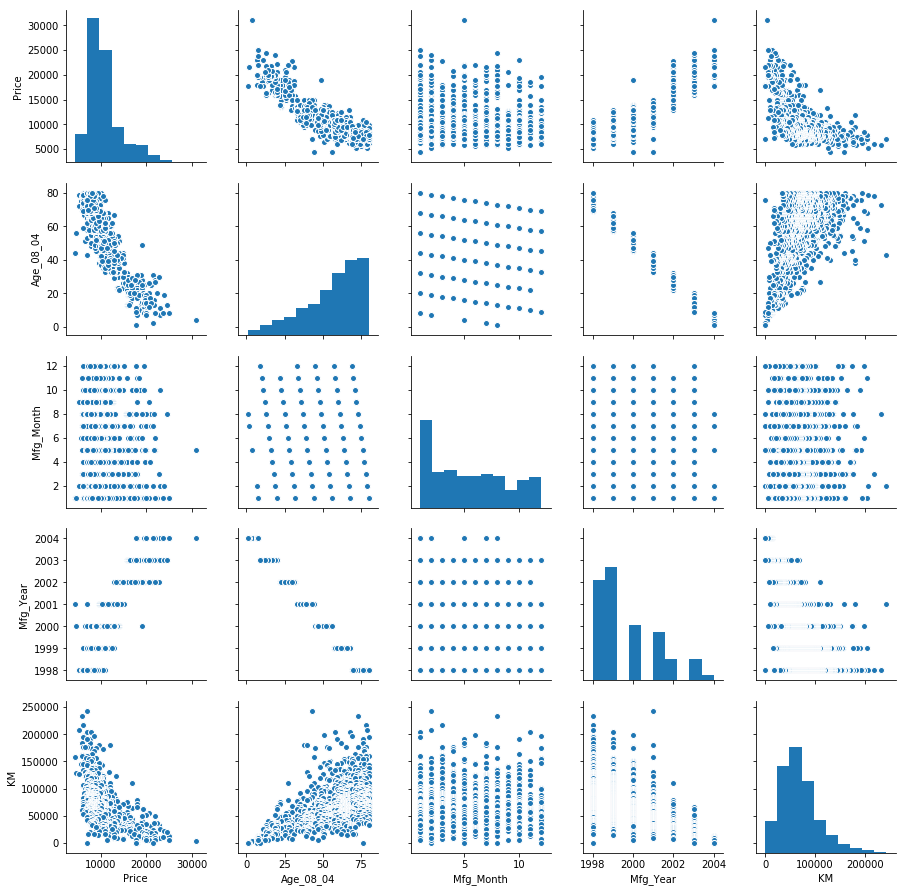

In [233]:
sns.pairplot(pd.concat([dfy['Price'], dfX[var_real[0:4]]], 1))
plt.show()
# Price와 음의 선형관계 : Age_08_04
# Price와 반비례 형상 : KM

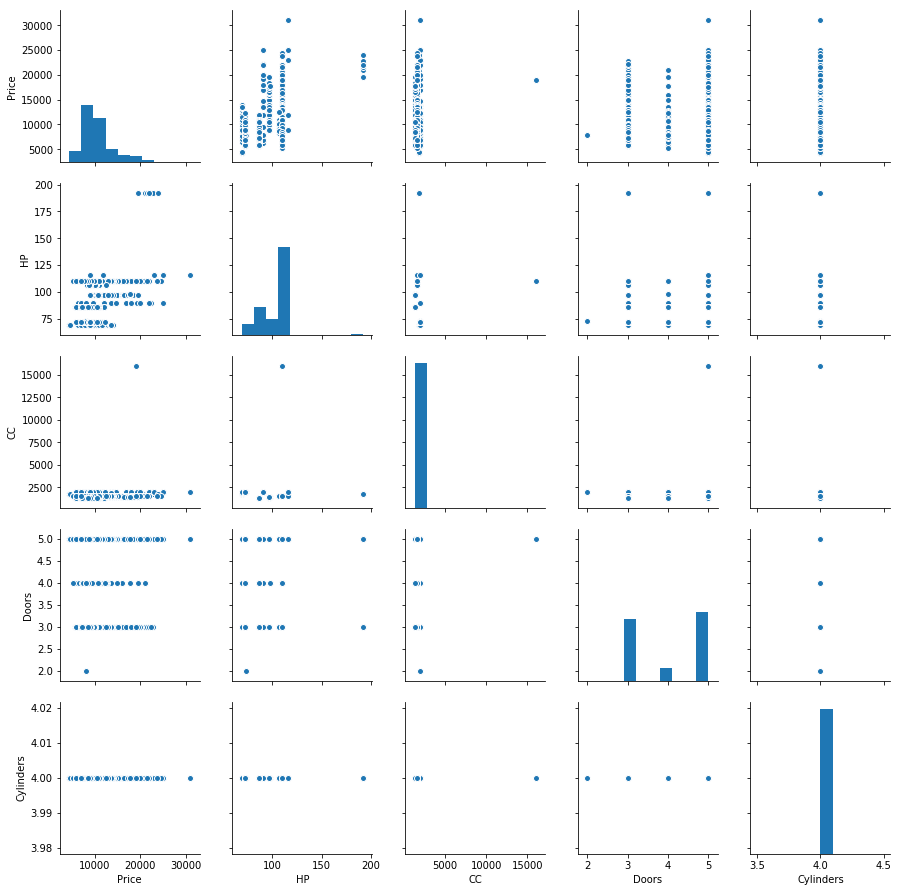

In [234]:
sns.pairplot(pd.concat([dfy['Price'], dfX[var_real[4:8]]], 1))
plt.show()
#실린더변수는 변수선택에서 제외

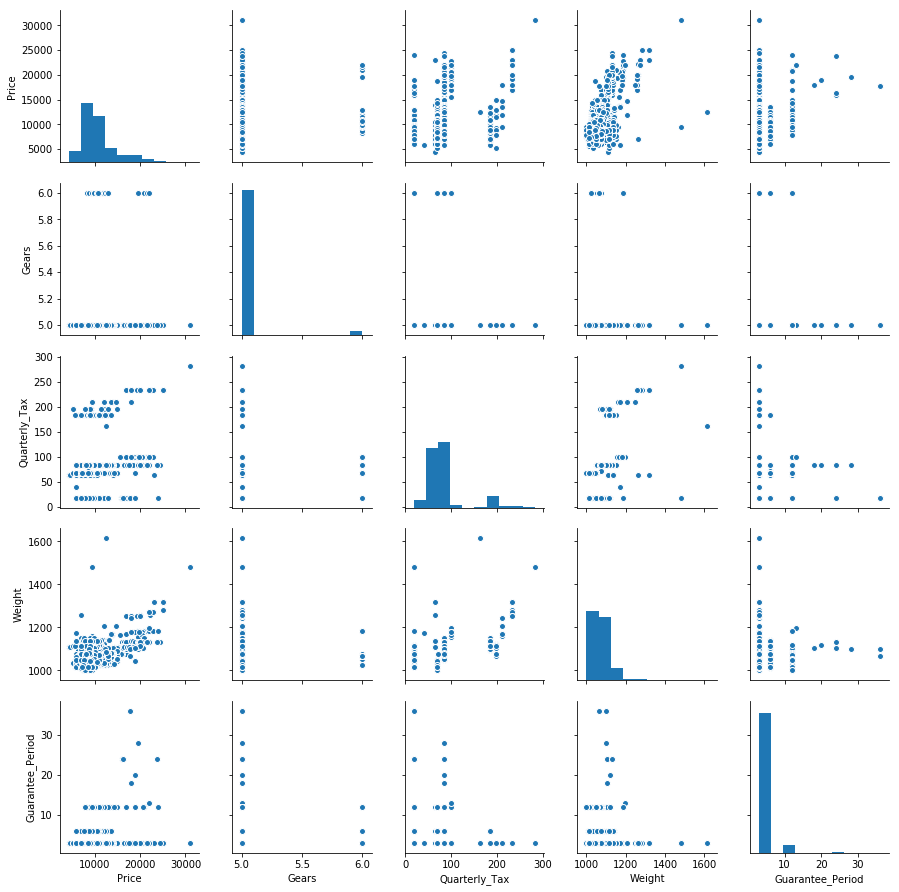

In [235]:
sns.pairplot(pd.concat([dfy['Price'], dfX[var_real[8:]]], 1))
plt.show()
#weight 비례관계가 있어 보임

### EDA 정리

    1. 종속 변수가 Price이니 항상 양수인 값이고 샘플 데이터의 히스토그램을 봤을 때 왼쪽으로 쏠린 형태이니 log를 취해주면 정규분포에 가까워지고 특정구간(Mode 미만의 구간)이 확장되는 효과가 있을 것이다. 
    
    2. 독립변수 KM은 Price에 대해 반비례 관계의 분포를 보임. Price와 함께 KM에도 로그를 취해주고 분포를 볼 필요가 있다.
    
    3. Age_08_04는 2004년 8월 시점에서 해당 자동차의 Age를 개월수로 나타낸 것이다. 그렇다면 이를 기준으로 제조년, 제조월은 역산할 수 있는 
    값이다.따라서 Age_08_04, Mfg_Year, Mfg_Month 중에서는 한 가지 변수만 선택하면 되지 않을까?
    Mfg_Year + Mfg_Month/12는 Age_08_04와 동일한 변수가 될 것 같다.
    
    4. Cylinder의 경우는 모든 데이터셋에서 4기통으로 되어 있으니 분포가 없는 데이터이므로 변수에서 제외

    5. Model 변수(256가지)에는 다른 변수에 있는 정보가 문자열 형태로 중복되서 표현되어 있음. Doors, CC, Sport 등... 
    하지만 다른 변수들에 담겨있지 않은 정보도 있다. 이런 정보들을 추출해서 변수로 활용할 것인가 말것인가? 
    우선 model은 독립변수에서 제외하고 회귀분석을 진행해본 후 쓸만한 데이터가 없으면 추출해보자
    
    6. Doors, Gears는 카테고리 변수로 봐야할 듯
    
   
> **  => 1. Price, Weight, KM에 로그를 취해보자 **

> **  => 2. Cylinder 변수는 변수선택에서 이미 탈락이다 **

> **  => 3. Model 변수는 일단 제외하고 선형회귀를 진행해보자 **

In [236]:
#변수 구분 다시
#Cylinders는 삭제
variables.remove('Cylinders')
var_real = ['Age_08_04', 'Mfg_Month', 'Mfg_Year', 'KM', 'CC', 'HP', 'Quarterly_Tax', 'Weight', 'Guarantee_Period']
var_cat = []
for var in variables:
    if var not in var_real:
        var_cat.append(var)
print(len(var_real))
print(len(var_cat))
print(var_cat)


9
26
['Fuel_Type', 'Met_Color', 'Color', 'Automatic', 'Doors', 'Gears', 'Mfr_Guarantee', 'BOVAG_Guarantee', 'ABS', 'Airbag_1', 'Airbag_2', 'Airco', 'Automatic_airco', 'Boardcomputer', 'CD_Player', 'Central_Lock', 'Powered_Windows', 'Power_Steering', 'Radio', 'Mistlamps', 'Sport_Model', 'Backseat_Divider', 'Metallic_Rim', 'Radio_cassette', 'Parking_Assistant', 'Tow_Bar']


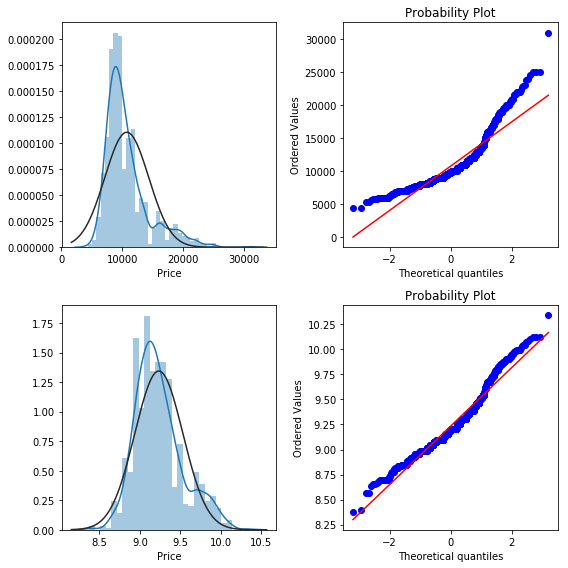

In [237]:
# Price에 로그 취하기 전후 비교: Log를 취하면 정규분포에 가까워진다
plt.figure(figsize=(8,8))
plt.subplot(221); sns.distplot(dfy['Price'], fit=sp.stats.norm);
plt.subplot(222); sp.stats.probplot(dfy['Price'], plot=plt)
plt.subplot(223); sns.distplot(np.log(dfy['Price']), fit=sp.stats.norm);
plt.subplot(224); sp.stats.probplot(np.log(dfy['Price']), plot=plt)
plt.tight_layout()
plt.show()

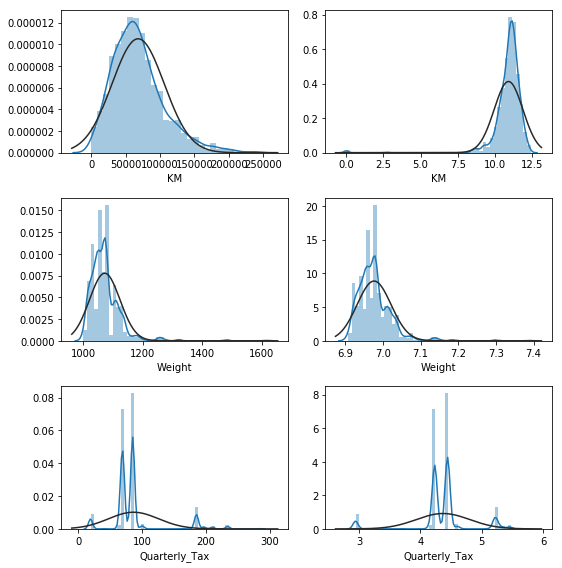

In [141]:
# KM, Weight, Quarterly_Tax에도 로그를 취한 전후 비교: Weight는 로그를 취한 결과가 더 정규분포에 가까워 보임.
# KM의 경우는 이상치 때문에 영향을 받는 것으로 보임(누적 주행거리가 1km, 15km에 불과한 데이터들이 있었음)
plt.figure(figsize=(8,8))
plt.subplot(321); sns.distplot(dfX['KM'], fit=sp.stats.norm); 
plt.subplot(322); sns.distplot(np.log(dfX['KM']), fit=sp.stats.norm)
plt.subplot(323); sns.distplot(df['Weight'], fit=sp.stats.norm)
plt.subplot(324); sns.distplot(np.log(df['Weight']), fit=sp.stats.norm)
plt.subplot(325); sns.distplot(df['Quarterly_Tax'], fit=sp.stats.norm)
plt.subplot(326); sns.distplot(np.log(df['Quarterly_Tax']), fit=sp.stats.norm)
plt.tight_layout()
plt.show()

    KM에 로그를 취한 분포가 왼쪽이 길게 늘어지는게 이상해서 데이터를 살펴봤더니 비정상 데이터가 보임
    CC에서 16000인 값도 발견(1600오타로 추정됨)

In [238]:
# KM 이상치를 확인하기 위해 변수 그룹을 확인함
dfX.groupby('KM').groups

{1: Int64Index([119, 171, 186, 1442], dtype='int64', name='Id'),
 15: Int64Index([185], dtype='int64', name='Id'),
 4000: Int64Index([112], dtype='int64', name='Id'),
 5000: Int64Index([170, 180], dtype='int64', name='Id'),
 5278: Int64Index([169], dtype='int64', name='Id'),
 5309: Int64Index([604], dtype='int64', name='Id'),
 5459: Int64Index([168], dtype='int64', name='Id'),
 6000: Int64Index([117, 167], dtype='int64', name='Id'),
 6155: Int64Index([166], dtype='int64', name='Id'),
 6250: Int64Index([179], dtype='int64', name='Id'),
 6500: Int64Index([165], dtype='int64', name='Id'),
 7000: Int64Index([87], dtype='int64', name='Id'),
 7187: Int64Index([109], dtype='int64', name='Id'),
 7650: Int64Index([164], dtype='int64', name='Id'),
 8537: Int64Index([86], dtype='int64', name='Id'),
 8574: Int64Index([177], dtype='int64', name='Id'),
 9750: Int64Index([31], dtype='int64', name='Id'),
 9788: Int64Index([176], dtype='int64', name='Id'),
 10000: Int64Index([38, 116, 163, 380], dtype=

In [239]:
# CC 이상치를 확인하기 위해 변수 그룹을 확인함
dfX.groupby('CC').groups

{1300: Int64Index([ 464,  496,  524,  541,  588,  590,  641,  650,  652,  660,
             ...
             1410, 1425, 1428, 1430, 1431, 1432, 1434, 1438, 1440, 1441],
            dtype='int64', name='Id', length=177),
 1332: Int64Index([845], dtype='int64', name='Id'),
 1398: Int64Index([606], dtype='int64', name='Id'),
 1400: Int64Index([ 31,  33,  34,  36,  37,  38,  39,  41,  42,  43,
             ...
             585, 586, 587, 592, 593, 596, 597, 599, 601, 603],
            dtype='int64', name='Id', length=114),
 1587: Int64Index([951, 1365], dtype='int64', name='Id'),
 1598: Int64Index([73, 163], dtype='int64', name='Id'),
 1600: Int64Index([  18,   20,   21,   22,   23,   24,   26,   27,   28,   30,
             ...
             1416, 1418, 1420, 1421, 1422, 1424, 1426, 1427, 1429, 1442],
            dtype='int64', name='Id', length=608),
 1800: Int64Index([11, 13, 14, 16, 17, 54, 143, 193, 396], dtype='int64', name='Id'),
 1900: Int64Index([188, 195, 196, 198, 205, 206, 212,

In [240]:
#확인만 해두고 제거여부는 나중에 결정

### 상관관계 살펴보기 
    
    연속확률 변수와 카테고리 변수로 나눠서 분석
    Model, Cylinders 변수는 제거

In [241]:
print(var_real)
print(var_cat)

['Age_08_04', 'Mfg_Month', 'Mfg_Year', 'KM', 'CC', 'HP', 'Quarterly_Tax', 'Weight', 'Guarantee_Period']
['Fuel_Type', 'Met_Color', 'Color', 'Automatic', 'Doors', 'Gears', 'Mfr_Guarantee', 'BOVAG_Guarantee', 'ABS', 'Airbag_1', 'Airbag_2', 'Airco', 'Automatic_airco', 'Boardcomputer', 'CD_Player', 'Central_Lock', 'Powered_Windows', 'Power_Steering', 'Radio', 'Mistlamps', 'Sport_Model', 'Backseat_Divider', 'Metallic_Rim', 'Radio_cassette', 'Parking_Assistant', 'Tow_Bar']


In [242]:
df_real = pd.concat([dfy['Price'], dfX[var_real]], axis = 1)
df_cat = pd.concat([dfy['Price'], dfX[var_cat]], axis = 1)

### 종속변수와 독립변수(연속 & 이산) 상관관계  살펴보기 

   * 해당되는 변수들은 서로를 설명할 수 있는 변수라고 보고 1개만 선택
   
   * 상관계수만으로 판단했을 때 서로 종속관계라고 볼 수 있는 독립변수는 없다고 생각된다.

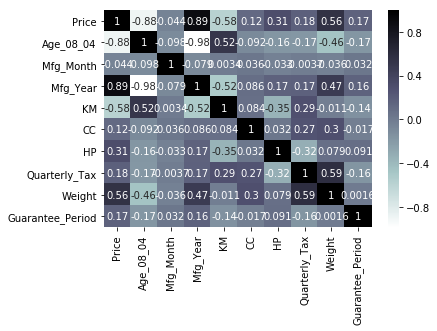

In [243]:
import matplotlib as mpl

cor_var_real = df_real.corr()
sns.heatmap(cor_var_real, annot=True, cmap=mpl.cm.bone_r)
plt.show()

In [244]:
temp= dmatrix("Price + Age_08_04 + I(Mfg_Year + Mfg_Month/12) - 1", df_real)

In [245]:
# Age_08_04와 (Mfg_Year + Mfg_Month/12)의 상관계수 = -1
# 서로 완벽하게 설명되므로 한쪽은 사용하지 않는다. Age_08_04를 사용하기로 함. 
print(pd.DataFrame(temp).corr())
sp.stats.pearsonr(temp[1], temp[2])

        0       1       2
0  1.0000 -0.8839  0.8839
1 -0.8839  1.0000 -1.0000
2  0.8839 -1.0000  1.0000


(0.99999988800422623, 0.00030129778721698996)

In [568]:
# 이렇게 연속확률변수의 경우 Price와의 상관계수를 구했으니 이것으로 상관계수 기준을 정해 변수를 선택하면 될까?

# 상관계수도 Sample에 의존적인 확률변수(student - t 분포를 따름)
# https://en.wikipedia.org/wiki/Pearson_correlation_coefficient
# 귀무가설: 상관계수는 0이다. 상관관계가 없다
# 대립가설: 상관관계가 있다.
# => 유의확률 체크 필요

In [247]:
for var in var_real:
    print(var, sp.stats.pearsonr(df['Price'], df[var]))

Age_08_04 (-0.88389997596143111, 0.0)
Mfg_Month (-0.044254842642569896, 0.1580527380684954)
Mfg_Year (0.8933019763297112, 0.0)
KM (-0.57596185216445739, 4.2103663413920063e-91)
CC (0.12041523051861473, 0.00011659418067070085)
HP (0.31489825814758804, 6.8285036237063916e-25)
Quarterly_Tax (0.17887374583572183, 8.9566258633661347e-09)
Weight (0.55701487105264824, 4.1793981498584848e-84)
Guarantee_Period (0.16614089142820712, 9.6010919331717011e-08)


In [248]:
# Mfg_Year, Mfg_Month대신 Age_08_04를 선택
# 유의수준 0.05를 적용하면 KM, HP, Quarterly_Tax, Weight, Guarantee_Period 도 대립가설 채택되므로 변수로 선택

In [249]:
var_real = ['Age_08_04', 'KM', 'HP', 'Quarterly_Tax', 'Weight', 'CC', 'Guarantee_Period']

# 4. 변수선택

### 종속변수와 카테고리 확률변수간의 관계
    1. 독립 표본 t-검정 (Independent-two-sample t-test)
    2. f-검정
    3. violinplot

In [250]:
for var in var_cat:
    tmp_list = df[var].unique()
    print(var, ':', tmp_list)

Fuel_Type : ['Diesel' 'Petrol' 'CNG']
Met_Color : [1 0]
Color : ['Blue' 'Silver' 'Black' 'Red' 'Grey' 'Green' 'White' 'Yellow' 'Violet'
 'Beige']
Automatic : [0 1]
Doors : [3 5 4 2]
Gears : [5 6]
Mfr_Guarantee : [0 1]
BOVAG_Guarantee : [1 0]
ABS : [1 0]
Airbag_1 : [1 0]
Airbag_2 : [1 0]
Airco : [0 1]
Automatic_airco : [0 1]
Boardcomputer : [1 0]
CD_Player : [0 1]
Central_Lock : [1 0]
Powered_Windows : [1 0]
Power_Steering : [1 0]
Radio : [0 1]
Mistlamps : [0 1]
Sport_Model : [0 1]
Backseat_Divider : [1 0]
Metallic_Rim : [0 1]
Radio_cassette : [0 1]
Parking_Assistant : [0 1]
Tow_Bar : [0 1]


In [251]:
var_cat_t = []
var_cat_f = ['Fuel_Type', 'Color', 'Doors']
for var in var_cat:
    if var not in var_cat_f:
        var_cat_t.append(var)
print("var_cat_t", '\n', var_cat_t)
print('\n')
print('var_cat_f', '\n', var_cat_f)

var_cat_t 
 ['Met_Color', 'Automatic', 'Gears', 'Mfr_Guarantee', 'BOVAG_Guarantee', 'ABS', 'Airbag_1', 'Airbag_2', 'Airco', 'Automatic_airco', 'Boardcomputer', 'CD_Player', 'Central_Lock', 'Powered_Windows', 'Power_Steering', 'Radio', 'Mistlamps', 'Sport_Model', 'Backseat_Divider', 'Metallic_Rim', 'Radio_cassette', 'Parking_Assistant', 'Tow_Bar']


var_cat_f 
 ['Fuel_Type', 'Color', 'Doors']


In [252]:
# t-test의 유의수준은 우선 5%로 정함
for var in var_cat_t:
    class_list = df[var].unique()
    x1 = df['Price'][df[var] == class_list[0]]
    x2 = df['Price'][df[var] == class_list[1]]
    var_cat1_t_result = sp.stats.ttest_ind(x1, x2, equal_var=True)
    if var_cat1_t_result[1] >= 0.05:
        print(var, ':', 'p-value=', var_cat1_t_result[1], 't =', var_cat1_t_result[0])

Gears : p-value= 0.088088936483 t = -1.70720634345
BOVAG_Guarantee : p-value= 0.257340657291 t = 1.13333509455
Radio : p-value= 0.448874747628 t = 0.757585349738
Radio_cassette : p-value= 0.434161706357 t = 0.78239992536
Parking_Assistant : p-value= 0.153071047351 t = -1.42983658666


In [253]:
# 위의 4개 항목은 변수에서 제외

In [254]:
var_cat_f

['Fuel_Type', 'Color', 'Doors']

In [255]:
# Fuel_Type

In [256]:
class_list = df['Fuel_Type'].unique()
class_list

array(['Diesel', 'Petrol', 'CNG'], dtype=object)

In [257]:
d1 = df['Price'][df['Fuel_Type'] == 'Diesel']
d2 = df['Price'][df['Fuel_Type'] == 'Petrol']
d3 = df['Price'][df['Fuel_Type'] == 'CNG']
sp.stats.f_oneway(d1, d2, d3)

F_onewayResult(statistic=0.2580949965666503, pvalue=0.77257247583343869)

In [258]:
# Fuel_Type은 귀무가설 채택. 즉, Price는 Fuel_Type 클래스에 따른 유의미한 차이가 없음

In [259]:
# Color

In [260]:
class_list = df['Color'].unique()
class_list

array(['Blue', 'Silver', 'Black', 'Red', 'Grey', 'Green', 'White',
       'Yellow', 'Violet', 'Beige'], dtype=object)

In [261]:
d1 = df['Price'][df['Color'] == 'Blue']
d2 = df['Price'][df['Color'] == 'Silver']
d3 = df['Price'][df['Color'] == 'Black']
d4 = df['Price'][df['Color'] == 'Red']
d5 = df['Price'][df['Color'] == 'Grey']
d6 = df['Price'][df['Color'] == 'Green']
d7 = df['Price'][df['Color'] == 'White']
d8 = df['Price'][df['Color'] == 'Yellow']
d9 = df['Price'][df['Color'] == 'Violet']
d10 = df['Price'][df['Color'] == 'Beige']
sp.stats.f_oneway(d1, d2, d3, d4, d5, d6, d7, d8, d9, d10)

F_onewayResult(statistic=6.4992939839072186, pvalue=4.9278984813640487e-09)

In [262]:
# Color는 귀무가설 기각. 즉, Price는 Color의 각 클래스에 따른 유의미한 차이가 있음

In [263]:
# CC

In [264]:
class_list = df['CC'].unique()
class_list

array([ 2000,  1800,  1600,  1400,  1598, 16000,  1995,  1900,  1300,
        1398,  1332,  1587])

In [265]:
df.groupby('CC').groups
#df[['CC', 'HP']]

{1300: Int64Index([ 464,  496,  524,  541,  588,  590,  641,  650,  652,  660,
             ...
             1410, 1425, 1428, 1430, 1431, 1432, 1434, 1438, 1440, 1441],
            dtype='int64', name='Id', length=177),
 1332: Int64Index([845], dtype='int64', name='Id'),
 1398: Int64Index([606], dtype='int64', name='Id'),
 1400: Int64Index([ 31,  33,  34,  36,  37,  38,  39,  41,  42,  43,
             ...
             585, 586, 587, 592, 593, 596, 597, 599, 601, 603],
            dtype='int64', name='Id', length=114),
 1587: Int64Index([951, 1365], dtype='int64', name='Id'),
 1598: Int64Index([73, 163], dtype='int64', name='Id'),
 1600: Int64Index([  18,   20,   21,   22,   23,   24,   26,   27,   28,   30,
             ...
             1416, 1418, 1420, 1421, 1422, 1424, 1426, 1427, 1429, 1442],
            dtype='int64', name='Id', length=608),
 1800: Int64Index([11, 13, 14, 16, 17, 54, 143, 193, 396], dtype='int64', name='Id'),
 1900: Int64Index([188, 195, 196, 198, 205, 206, 212,

In [266]:
d1 = df['Price'][df['CC'] == 2000]
d2 = df['Price'][df['CC'] == 1800]
d3 = df['Price'][df['CC'] == 1600]
d4 = df['Price'][df['CC'] == 1400]
d5 = df['Price'][df['CC'] == 1598]
d6 = df['Price'][df['CC'] == 1995]
d7 = df['Price'][df['CC'] == 1900]
d8 = df['Price'][df['CC'] == 1300]
d9 = df['Price'][df['CC'] == 1398]
d10 = df['Price'][df['CC'] == 1332]
d11 = df['Price'][df['CC'] == 1587]
sp.stats.f_oneway(d1, d2, d3, d4, d5, d6, d7, d8, d9, d10, d11)

F_onewayResult(statistic=20.082852007443304, pvalue=3.7392285912040307e-34)

In [267]:
# CC는 귀무가설 기각. 즉, Price는 CC의 각 클래스에 따른 유의미한 차이가 있음

In [268]:
# Doors

In [269]:
class_list = df['Doors'].unique()
class_list

array([3, 5, 4, 2])

In [270]:
d1 = df['Price'][df['Doors'] == 3]
d2 = df['Price'][df['Doors'] == 5]
d3 = df['Price'][df['Doors'] == 4]
d4 = df['Price'][df['Doors'] == 2]
sp.stats.f_oneway(d1, d2, d3, d4)

F_onewayResult(statistic=13.157426161496677, pvalue=1.9673598160670142e-08)

In [271]:
# CC는 귀무가설 기각. 즉, Price는 Doors의 각 클래스에 따른 유의미한 차이가 있음

### 카테고리 변수 중 선택에서 제외

In [272]:
drops_cat = ['Gears', 'BOVAG_Guarantee', 'Radio', 'Radio_cassette', 'Parking_Assistant', 'Fuel_Type']

In [273]:
for var in var_cat:
    if var in drops_cat:
        var_cat.remove(var)

print(len(var_cat), var_cat)

21 ['Met_Color', 'Color', 'Automatic', 'Doors', 'Mfr_Guarantee', 'ABS', 'Airbag_1', 'Airbag_2', 'Airco', 'Automatic_airco', 'Boardcomputer', 'CD_Player', 'Central_Lock', 'Powered_Windows', 'Power_Steering', 'Mistlamps', 'Sport_Model', 'Backseat_Divider', 'Metallic_Rim', 'Parking_Assistant', 'Tow_Bar']


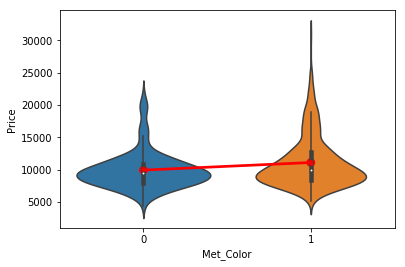

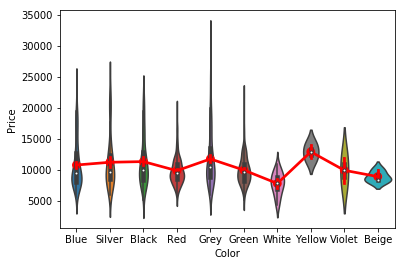

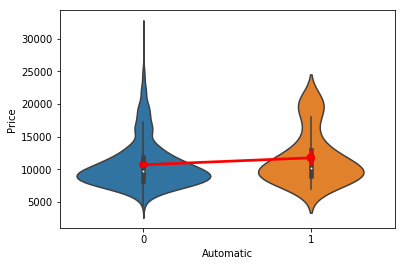

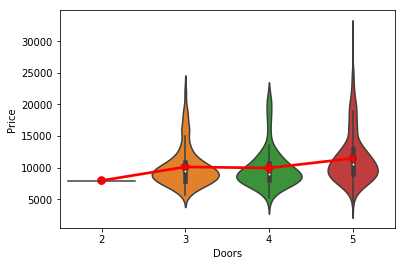

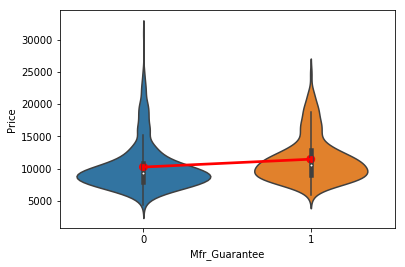

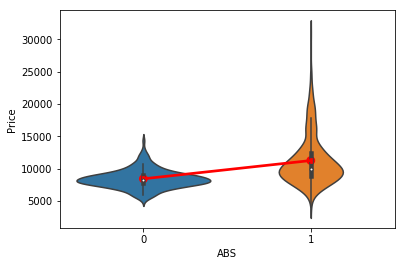

In [573]:
for var in var_cat[:6]:
    sns.violinplot(x=var, y="Price", data=df, jitter=True, alpha=.3)
    sns.pointplot(x=var, y="Price", data=df, dodge=True, color='r')
    plt.show()

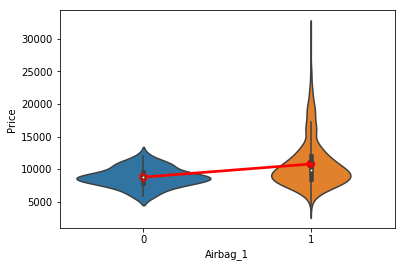

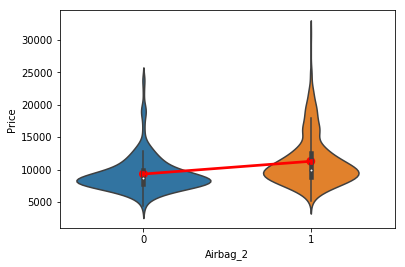

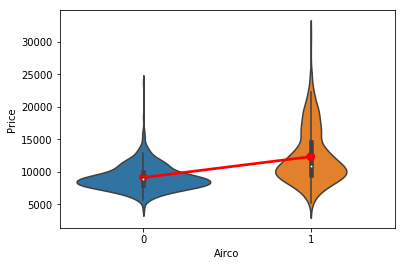

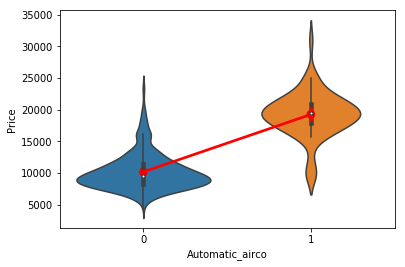

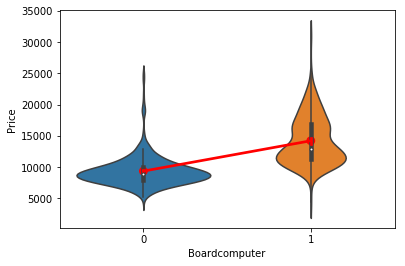

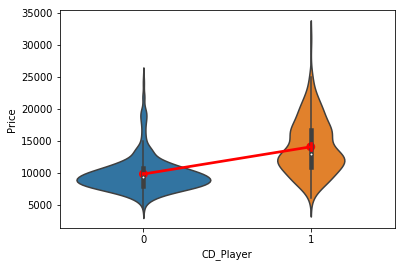

In [574]:
for var in var_cat[6:12]:
    sns.violinplot(x=var, y="Price", data=df, jitter=True, alpha=.3)
    sns.pointplot(x=var, y="Price", data=df, dodge=True, color='r')
    plt.show()

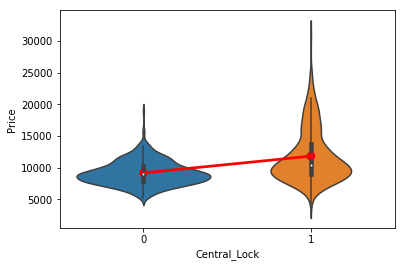

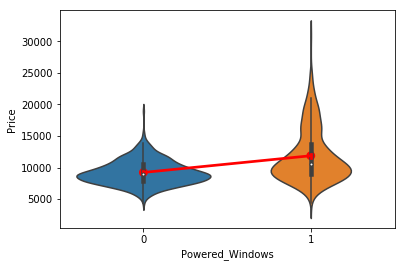

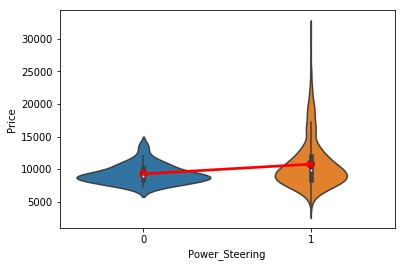

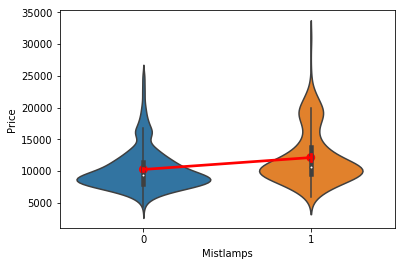

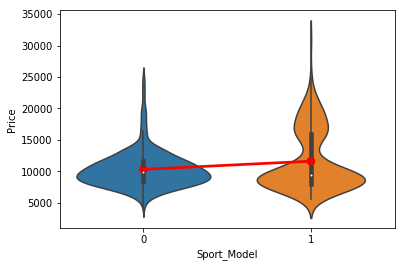

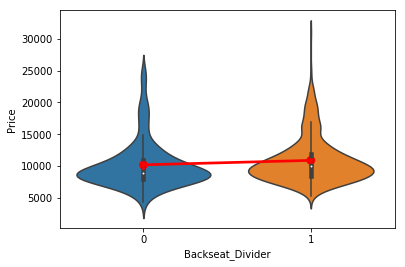

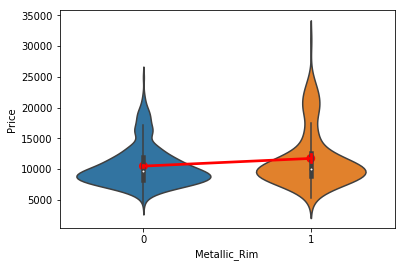

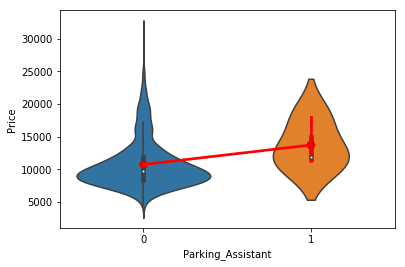

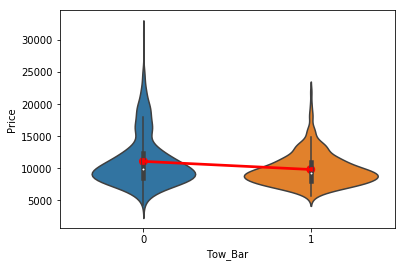

In [575]:
for var in var_cat[12:]:
    sns.violinplot(x=var, y="Price", data=df, jitter=True, alpha=.3)
    sns.pointplot(x=var, y="Price", data=df, dodge=True, color='r')
    plt.show()

In [275]:
del dfy['Model']
dfX = pd.concat([df[var_real], df[var_cat]], 1)

In [276]:
df = pd.concat([dfX, dfy], 1)

# 5. 회귀모형의 가정, 진단 및 개선

In [277]:
var_real

['Age_08_04', 'KM', 'HP', 'Quarterly_Tax', 'Weight', 'CC', 'Guarantee_Period']

In [278]:
df.columns

Index(['Age_08_04', 'KM', 'HP', 'Quarterly_Tax', 'Weight', 'CC',
       'Guarantee_Period', 'Met_Color', 'Color', 'Automatic', 'Doors',
       'Mfr_Guarantee', 'ABS', 'Airbag_1', 'Airbag_2', 'Airco',
       'Automatic_airco', 'Boardcomputer', 'CD_Player', 'Central_Lock',
       'Powered_Windows', 'Power_Steering', 'Mistlamps', 'Sport_Model',
       'Backseat_Divider', 'Metallic_Rim', 'Parking_Assistant', 'Tow_Bar',
       'Price'],
      dtype='object')

In [279]:
dfX_1 = dfX.copy()
df_1 = pd.concat([dfX_1, dfy], 1)

In [280]:
model_1 = sm.OLS.from_formula("np.log(Price) ~ \
                            scale(Age_08_04) + scale(np.log(KM)) + scale(HP) + scale(Quarterly_Tax) + \
                            scale(np.log(Weight)) + scale(Guarantee_Period) + \
                            C(Met_Color) + C(Color) + C(Automatic)+ C(CC) + C(Doors) + C(Mfr_Guarantee) + \
                            C(ABS) + C(Airbag_1) + C(Airbag_2) + C(Airco) + C(Automatic_airco) + C(Boardcomputer) + \
                            C(CD_Player) + C(Central_Lock) + C(Powered_Windows) + C(Power_Steering) + C(Mistlamps) + \
                            C(Sport_Model) + C(Backseat_Divider) + C(Metallic_Rim) + C(Tow_Bar)", data = df_1)
                              
result_1 = model_1.fit()
print(result_1.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(Price)   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     129.7
Date:                Wed, 25 Oct 2017   Prob (F-statistic):               0.00
Time:                        01:05:04   Log-Likelihood:                 802.52
No. Observations:                1019   AIC:                            -1509.
Df Residuals:                     971   BIC:                            -1273.
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [283]:
# 귀무가설 채택: 
#    Met_Color, Color, Doors, ABS, Airbag_1, Airbag_2, Airco, Broadcomputer, CD_Plyer 
#    Central_Lock, Powered_Windows, Power_Steering, Mistlamps, Sport_Model, Backseat_Divider, Metallic_Rim, Tow_Bar

#    Quaterly_Tax, Weight, Guarantee_Period 

# 클래스 별로 귀무가설 채택:
#    CC : 데이터 조작 필요

In [284]:
dfX_2 = dfX.copy()
dfX_2.head()

,Age_08_04,KM,HP,Quarterly_Tax,Weight,CC,Guarantee_Period,Met_Color,Color,Automatic,...,CD_Player,Central_Lock,Powered_Windows,Power_Steering,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Parking_Assistant,Tow_Bar
Id,,,,,,,,,,,,,,,,,,,,,
1,23,46986,90,210,1165,2000,3,1,Blue,0,...,0,1,1,1,0,0,1,0,0,0
2,23,72937,90,210,1165,2000,3,1,Silver,0,...,1,1,0,1,0,0,1,0,0,0
5,30,38500,90,210,1170,2000,3,0,Black,0,...,0,1,1,1,1,0,1,0,0,0
11,25,31461,192,100,1185,1800,12,0,Silver,0,...,1,1,1,1,0,0,0,1,0,0
13,25,32189,192,100,1185,1800,3,0,Red,0,...,0,1,1,1,1,1,1,1,0,0


In [285]:
# 데이터 중 CC가 1332, 1398, 1587, 1598, 1900, 2000인 경우는 귀무가설 채택 => 이에 해당하는 CC = 1300 값으로 이동 
# CC가 1300, 1400, 1600, 1800인 경우는 대립가설 채택

In [286]:
def cc_adj(cc):
    if cc == 1332:
        return 1300
    
    elif cc == 1398:
        return 1300
    
    elif cc == 1587:
        return 1300
    
    elif cc == 1598:
        return 1300
    
    elif cc == 1900:
        return 1300
    
    elif cc == 1995:
        return 1300
    
    elif cc == 2000:
        return 1300
    
    elif cc == 16000:
        return 1600
    
    else:
        return cc

In [287]:
dfX_2['CC'] = dfX_2['CC'].apply(cc_adj)

In [288]:
dfX_2.groupby('CC').groups

{1300: Int64Index([   1,    2,    5,   44,   47,   49,   73,   88,   92,   93,
             ...
             1410, 1425, 1428, 1430, 1431, 1432, 1434, 1438, 1440, 1441],
            dtype='int64', name='Id', length=287),
 1400: Int64Index([ 31,  33,  34,  36,  37,  38,  39,  41,  42,  43,
             ...
             585, 586, 587, 592, 593, 596, 597, 599, 601, 603],
            dtype='int64', name='Id', length=114),
 1600: Int64Index([  18,   20,   21,   22,   23,   24,   26,   27,   28,   30,
             ...
             1416, 1418, 1420, 1421, 1422, 1424, 1426, 1427, 1429, 1442],
            dtype='int64', name='Id', length=609),
 1800: Int64Index([11, 13, 14, 16, 17, 54, 143, 193, 396], dtype='int64', name='Id')}

In [289]:
dfX_2.head()

,Age_08_04,KM,HP,Quarterly_Tax,Weight,CC,Guarantee_Period,Met_Color,Color,Automatic,...,CD_Player,Central_Lock,Powered_Windows,Power_Steering,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Parking_Assistant,Tow_Bar
Id,,,,,,,,,,,,,,,,,,,,,
1,23,46986,90,210,1165,1300,3,1,Blue,0,...,0,1,1,1,0,0,1,0,0,0
2,23,72937,90,210,1165,1300,3,1,Silver,0,...,1,1,0,1,0,0,1,0,0,0
5,30,38500,90,210,1170,1300,3,0,Black,0,...,0,1,1,1,1,0,1,0,0,0
11,25,31461,192,100,1185,1800,12,0,Silver,0,...,1,1,1,1,0,0,0,1,0,0
13,25,32189,192,100,1185,1800,3,0,Red,0,...,0,1,1,1,1,1,1,1,0,0


In [290]:
df_2 = pd.concat([dfX_2, dfy], 1)
df_2 = df_2

In [291]:
model_2 = sm.OLS.from_formula("np.log(Price) ~ \
                            scale(Age_08_04) + scale(np.log(KM)) + scale(HP) + \
                            C(Automatic) + C(CC) + C(Mfr_Guarantee) + \
                            C(Automatic_airco) \
                            ", data = df_2)
                              
result_2 = model_2.fit()
print(result_2.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(Price)   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     583.2
Date:                Wed, 25 Oct 2017   Prob (F-statistic):               0.00
Time:                        01:09:01   Log-Likelihood:                 720.94
No. Observations:                1019   AIC:                            -1422.
Df Residuals:                    1009   BIC:                            -1373.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [70]:
# scale(np.log(KM))에 대해 귀무가설 채택 전 점검

In [71]:
df_2.groupby('KM').groups

{1: Int64Index([119, 171, 186, 1442], dtype='int64', name='Id'),
 15: Int64Index([185], dtype='int64', name='Id'),
 4000: Int64Index([112], dtype='int64', name='Id'),
 5000: Int64Index([170, 180], dtype='int64', name='Id'),
 5278: Int64Index([169], dtype='int64', name='Id'),
 5309: Int64Index([604], dtype='int64', name='Id'),
 5459: Int64Index([168], dtype='int64', name='Id'),
 6000: Int64Index([117, 167], dtype='int64', name='Id'),
 6155: Int64Index([166], dtype='int64', name='Id'),
 6250: Int64Index([179], dtype='int64', name='Id'),
 6500: Int64Index([165], dtype='int64', name='Id'),
 7000: Int64Index([87], dtype='int64', name='Id'),
 7187: Int64Index([109], dtype='int64', name='Id'),
 7650: Int64Index([164], dtype='int64', name='Id'),
 8537: Int64Index([86], dtype='int64', name='Id'),
 8574: Int64Index([177], dtype='int64', name='Id'),
 9750: Int64Index([31], dtype='int64', name='Id'),
 9788: Int64Index([176], dtype='int64', name='Id'),
 10000: Int64Index([38, 116, 163, 380], dtype=

In [292]:
df_2 = df_2.drop([119])
df_2 = df_2.drop([171])
df_2 = df_2.drop([186])
df_2 = df_2.drop([1442])
df_2 = df_2.drop([185])
df_2.groupby('KM').groups

{4000: Int64Index([112], dtype='int64', name='Id'),
 5000: Int64Index([170, 180], dtype='int64', name='Id'),
 5278: Int64Index([169], dtype='int64', name='Id'),
 5309: Int64Index([604], dtype='int64', name='Id'),
 5459: Int64Index([168], dtype='int64', name='Id'),
 6000: Int64Index([117, 167], dtype='int64', name='Id'),
 6155: Int64Index([166], dtype='int64', name='Id'),
 6250: Int64Index([179], dtype='int64', name='Id'),
 6500: Int64Index([165], dtype='int64', name='Id'),
 7000: Int64Index([87], dtype='int64', name='Id'),
 7187: Int64Index([109], dtype='int64', name='Id'),
 7650: Int64Index([164], dtype='int64', name='Id'),
 8537: Int64Index([86], dtype='int64', name='Id'),
 8574: Int64Index([177], dtype='int64', name='Id'),
 9750: Int64Index([31], dtype='int64', name='Id'),
 9788: Int64Index([176], dtype='int64', name='Id'),
 10000: Int64Index([38, 116, 163, 380], dtype='int64', name='Id'),
 10077: Int64Index([174], dtype='int64', name='Id'),
 10210: Int64Index([603], dtype='int64', 

In [294]:
len(df_2)

1014

In [74]:
# KM 이상치를 지운 후 다시 시도
model_2 = sm.OLS.from_formula("np.log(Price) ~ \
                            scale(Age_08_04) + scale(np.log(KM)) + scale(HP) + \
                            C(Automatic) + C(CC) + C(Mfr_Guarantee) + \
                            C(Automatic_airco) \
                            ", data = df_2)
                              
result_2 = model_2.fit()
print(result_2.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(Price)   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     595.8
Date:                Tue, 24 Oct 2017   Prob (F-statistic):               0.00
Time:                        19:39:14   Log-Likelihood:                 735.43
No. Observations:                1014   AIC:                            -1451.
Df Residuals:                    1004   BIC:                            -1402.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [296]:
# Automatic 변수 제거

In [297]:
df_3 = df_2.copy()
len(df_3)

1014

In [298]:
model_3 = sm.OLS.from_formula("np.log(Price) ~ \
                            scale(Age_08_04) + scale(np.log(KM)) + scale(HP) + \
                            C(CC) + C(Mfr_Guarantee) + \
                            C(Automatic_airco) \
                            ", data = df_3)
                              
result_3 = model_3.fit()
print(result_3.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(Price)   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     663.4
Date:                Wed, 25 Oct 2017   Prob (F-statistic):               0.00
Time:                        01:12:45   Log-Likelihood:                 730.58
No. Observations:                1014   AIC:                            -1443.
Df Residuals:                    1005   BIC:                            -1399.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [300]:
sm.stats.anova_lm(result_3, type = 2)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df,sum_sq,mean_sq,F,PR(>F)
C(CC),3.0,10.552993,3.517664,251.576256,9.376859e-122
C(Mfr_Guarantee),1.0,1.974503,1.974503,141.212431,1.445953e-30
C(Automatic_airco),1.0,21.565360,21.565360,1542.310959,3.480828e-205
scale(Age_08_04),1.0,37.201917,37.201917,2660.605976,1.189489e-284
scale(np.log(KM)),1.0,1.442249,1.442249,103.146750,3.895193e-23
scale(HP),1.0,1.466966,1.466966,104.914452,1.735432e-23
Residual,1005.0,14.052410,0.013982,NaN,NaN


In [301]:
# KM 변수 선택에서 제외해도 될까? => Try!

In [302]:
df_4 = df_3.copy()

In [303]:
len(df_4)

1014

In [304]:
model_4 = sm.OLS.from_formula("np.log(Price) ~ \
                            scale(Age_08_04) + scale(HP) + \
                            C(CC) + C(Mfr_Guarantee) + \
                            C(Automatic_airco) \
                            ", data = df_4)
                              
result_4 = model_4.fit()
print(result_4.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(Price)   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     716.5
Date:                Wed, 25 Oct 2017   Prob (F-statistic):               0.00
Time:                        01:17:42   Log-Likelihood:                 706.21
No. Observations:                1014   AIC:                            -1396.
Df Residuals:                    1006   BIC:                            -1357.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [305]:
# 모형성능 비교
sm.stats.anova_lm(model_4.fit(), model_3.fit())

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1006.0,14.744385,0.0,NaN,NaN,NaN
1,1005.0,14.052410,1.0,0.691975,49.488662,3.685913e-12


In [ ]:
# 현 단계에서 회귀분석 모형은 모델3로 선정(모델 4에서 오히려 R^2값 감소)

# 6. 등분산성 검토

In [84]:
# 레버리지와 아웃라이어 찾기

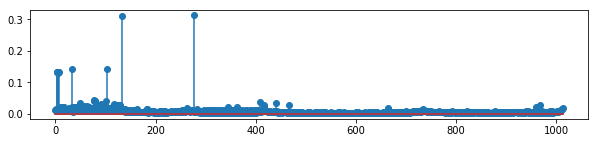

In [306]:
# 레버리지
# 잔차 그래프: log(dfy) - log(dfy_new) 형태로 나타남
# 종속변수에 로그값을 취했으므로 잔차에 크기도 로그가 취해진 값의 차이로 나타난다. 
influence = result_3.get_influence()
hat = influence.hat_matrix_diag

plt.figure(figsize=(10, 2))
plt.stem(hat)
plt.show()

In [307]:
print("hat.sum() =", hat.sum())

hat.sum() = 9.0


In [418]:
# 잔차를 이용해서 구한 레버리지
hat_limit =  9/1014
lvgs = np.where(hat > hat_limit*4)
lvgs

(array([  3,   4,   5,   6,   7,  34,  77,  78,  79,  80, 100, 102, 133,
        276, 408]),)

In [485]:
out_lvgs = df_3.iloc[lvgs]
out_lvgs

,Age_08_04,KM,HP,Quarterly_Tax,Weight,CC,Guarantee_Period,Met_Color,Color,Automatic,...,Central_Lock,Powered_Windows,Power_Steering,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Parking_Assistant,Tow_Bar,Price
Id,,,,,,,,,,,,,,,,,,,,,
11,25,31461,192,100,1185,1800,12,0,Silver,0,...,1,1,1,0,0,0,1,0,0,20950
13,25,32189,192,100,1185,1800,3,0,Red,0,...,1,1,1,1,1,1,1,0,0,19600
14,31,23000,192,100,1185,1800,3,1,Black,0,...,1,1,1,1,1,1,1,0,0,21500
16,28,18739,192,100,1185,1800,3,0,Grey,0,...,1,1,1,1,1,1,1,0,0,22000
17,30,34000,192,100,1185,1800,3,1,Grey,0,...,1,1,1,1,0,1,1,0,0,22750
54,27,49866,192,100,1195,1800,13,1,Green,0,...,1,1,1,0,0,0,1,0,0,21950
112,4,4000,116,283,1480,1300,3,1,Grey,0,...,1,1,1,1,1,1,1,0,0,31000
114,8,13253,116,234,1320,1300,3,1,Grey,0,...,1,1,1,0,0,0,0,0,0,24950
115,8,13253,116,234,1320,1300,3,1,Grey,0,...,1,1,1,0,0,0,0,0,0,24950


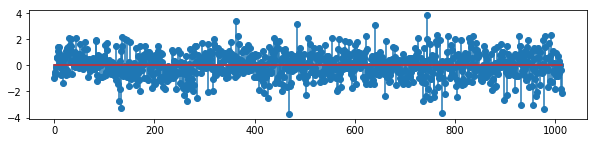

In [409]:
#표준화 잔차 그래프를 그려보면 다음과 같이 나타난다. 2에서 4 그리고 -4에서 -2 사이에 있으면 아웃라이어
plt.figure(figsize=(10, 2))
plt.stem(result_3.resid_pearson)
plt.show()

In [419]:
temp = result_3.resid_pearson
out_1 = np.where((temp>3) | (temp<-3))
out_1

(array([133, 362, 468, 485, 640, 744, 774, 932, 956, 978]),)

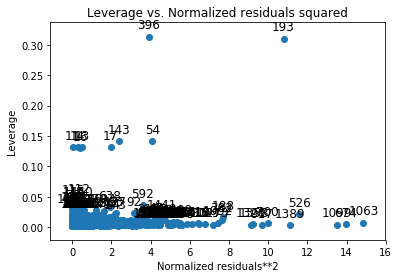

In [310]:
sm.graphics.plot_leverage_resid2(result_3)
plt.show()

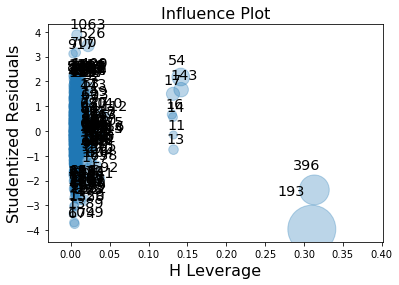

In [311]:
sm.graphics.influence_plot(result_3, plot_alpha=0.3)
plt.show()

In [435]:
from statsmodels.graphics import utils

cooks_d2, pvals = influence.cooks_distance
fox_cr = 4 / (len(df_4) - 9)
idx = np.where(cooks_d2 > fox_cr)[0]

In [436]:
# Fox recommentation 기준으로 선택한 아웃라이어 인덱스
idx

array([   4,    5,    6,    7,   28,   29,   33,   34,   44,   62,   83,
         84,  102,  124,  127,  130,  131,  133,  135,  141,  145,  259,
        264,  265,  276,  362,  408,  417,  418,  427,  441,  468,  485,
        737,  744,  750,  764,  774,  932,  956,  978,  992, 1011, 1013])

In [ ]:
# 이 아웃라이어들이 어느 위치에 분포해 있는지 확인해보기로 함

In [475]:
y_hat = result_3.predict(df_3.iloc[idx])
y_hat = np.exp(y_hat)
out_fox = pd.concat([df_3.iloc[idx][['Age_08_04','KM','CC','Mfr_Guarantee','Automatic_airco','HP','Price']], y_hat.rename('y_hat')], axis=1)
out_fox.tail(3)


,Age_08_04,KM,CC,Mfr_Guarantee,Automatic_airco,HP,Price,y_hat
Id,,,,,,,,
1409,78,47400,1300,1,0,86,10500,7994.090952
1438,69,20544,1300,1,0,86,7500,9335.388347
1441,70,16916,1300,1,0,86,7250,9328.103424


In [473]:
# Age_08_04 기준으로 본 가격 분포와 아웃라이어 추정 포인트
out_1 = outliers[np.log(outliers['Price']) < 8.5]
out_2 = outliers[(np.log(outliers['Price']) > 9.75) & (outliers['Age_08_04'] > 45)]

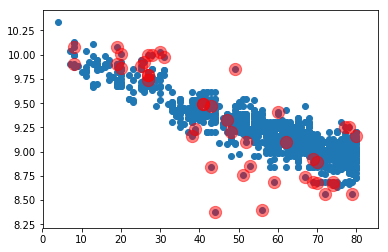

In [487]:
ax = plt.subplot()
plt.scatter(df_3['Age_08_04'], np.log(df_3['Price']))
plt.scatter(df_3['Age_08_04'].iloc[idx], np.log(df_3['Price'].iloc[idx]), s=150, c="r", alpha=0.5)
plt.show()

In [474]:
out_1

,Age_08_04,KM,CC,Mfr_Guarantee,Automatic_airco,HP,Price,y_hat
Id,,,,,,,,
193,44,158320,1800,0,0,69,4350,6402.778636
396,56,129155,1800,0,0,69,4450,5615.026096


In [453]:
out_2

,Age_08_04,KM,CC,Mfr_Guarantee,Automatic_airco,HP,Price,y_hat
Id,,,,,,,,
526,49,49568,1600,0,1,110,18950,12694.018139


In [488]:
# KM 기준으로 본 가격 분포와 아웃라이어 추정 포인트
out_3 = outliers[(np.log(outliers['Price']) < 9.5) & (np.log(outliers['KM']) < 9)]

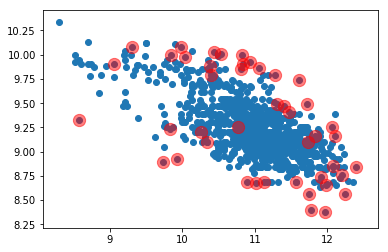

In [456]:
ax = plt.subplot()
plt.scatter(np.log(df_3['KM']), np.log(df_3['Price']))
plt.scatter(np.log(df_3['KM'].iloc[idx]), np.log(df_3['Price'].iloc[idx]), s=150, c="r", alpha=0.5)
plt.show()

In [489]:
out_3

,Age_08_04,KM,CC,Mfr_Guarantee,Automatic_airco,HP,Price,y_hat
Id,,,,,,,,
604,47,5309,1600,0,0,110,11250,13068.768993


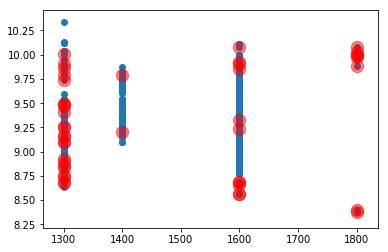

In [349]:
ax = plt.subplot()
plt.scatter(df_3['CC'], np.log(df_3['Price']))
plt.scatter(df_3['CC'].iloc[idx], np.log(df_3['Price'].iloc[idx]), s=150, c="r", alpha=0.5)
plt.show()

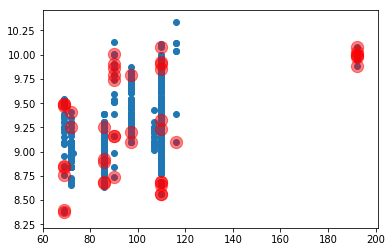

In [350]:
ax = plt.subplot()
plt.scatter(df_3['HP'], np.log(df_3['Price']))
plt.scatter(df_3['HP'].iloc[idx], np.log(df_3['Price'].iloc[idx]), s=150, c="r", alpha=0.5)
plt.show()

In [493]:
# 레버리지이면서 아웃라이어에 해당하는 Id
id_del = [13, 14, 16, 17, 54, 143, 193, 396, 592]

In [531]:
# 레버리지이면서 fox recommendation 기준에 부합하는 아웃라이어 데이터 지우기
#df_4는 이미 앞에서 사용한 번호이므로...
df_5 = df_3.copy()

# 7. 개선된 다중회귀 검토

In [533]:
for i in id_del:
    df_5 = df_5.drop([i])

In [534]:
df_5.head()

,Age_08_04,KM,HP,Quarterly_Tax,Weight,CC,Guarantee_Period,Met_Color,Color,Automatic,...,Central_Lock,Powered_Windows,Power_Steering,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Parking_Assistant,Tow_Bar,Price
Id,,,,,,,,,,,,,,,,,,,,,
1,23,46986,90,210,1165,1300,3,1,Blue,0,...,1,1,1,0,0,1,0,0,0,13500
2,23,72937,90,210,1165,1300,3,1,Silver,0,...,1,0,1,0,0,1,0,0,0,13750
5,30,38500,90,210,1170,1300,3,0,Black,0,...,1,1,1,1,0,1,0,0,0,13750
11,25,31461,192,100,1185,1800,12,0,Silver,0,...,1,1,1,0,0,0,1,0,0,20950
18,24,21716,110,85,1105,1600,18,1,Blue,0,...,1,1,1,0,0,0,0,0,1,17950


In [535]:
model_5 = sm.OLS.from_formula("np.log(Price) ~ \
                            scale(Age_08_04) + scale(np.log(KM)) + scale(HP) + \
                            C(CC) + C(Mfr_Guarantee) + \
                            C(Automatic_airco) \
                            ", data = df_5)
                              
result_5 = model_5.fit()
print(result_5.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(Price)   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     649.5
Date:                Wed, 25 Oct 2017   Prob (F-statistic):               0.00
Time:                        04:36:58   Log-Likelihood:                 743.49
No. Observations:                1005   AIC:                            -1469.
Df Residuals:                     996   BIC:                            -1425.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [603]:
df_6 = df_5.copy()

In [605]:
model_6 = sm.OLS.from_formula("np.log(Price) ~ scale(Age_08_04) + scale(np.log(KM)) + \
                            C(Mfr_Guarantee) + C(Automatic_airco) \
                            ", data = df_6)
                              
result_6 = model_6.fit()
print(result_6.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(Price)   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     1224.
Date:                Wed, 25 Oct 2017   Prob (F-statistic):               0.00
Time:                        06:16:48   Log-Likelihood:                 716.99
No. Observations:                1005   AIC:                            -1424.
Df Residuals:                    1000   BIC:                            -1399.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

# 8. 이분산성  검토

In [617]:
dfy_new = result_6.predict(df_6)

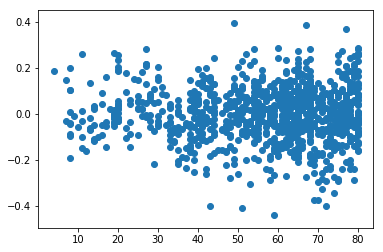

In [618]:
# 잔차의 분포
plt.scatter(df_6['Age_08_04'] , result_6.resid)
plt.show()

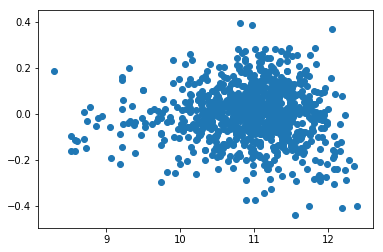

In [619]:
plt.scatter(np.log(df_6['KM']) , result_6.resid)
plt.show()

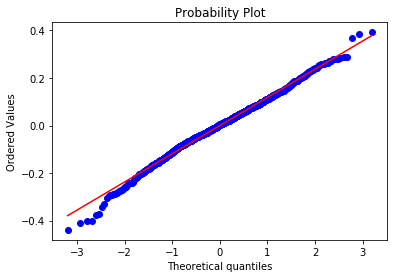

In [620]:
# 잔차의 Q-Q 플롯
sp.stats.probplot(result_6.resid, plot=plt)
plt.show()

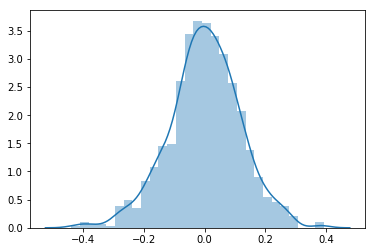

In [621]:
# 잔차의 분포형태
sns.distplot(result_6.resid)
plt.show()

# 9. 최종 회귀모형 선택

In [557]:
from sklearn.metrics import mean_squared_error

In [616]:
''' 
아래 세 가지 항목 설정
1) basic_fomula
2) N
3) df_f
'''

# fomula
basis_fomula = "np.log(Price) ~ scale(Age_08_04) + scale(np.log(KM)) + C(Mfr_Guarantee) + C(Automatic_airco)"


# split 비율
N=5

scores = np.zeros(N)
cv = sklearn.model_selection.KFold(N)

train_X = df_6
train_y = train_X['Price']

for i, (train_index, test_index) in enumerate(cv.split(train_X)):

    X_train = train_X.iloc[train_index]
    y_train = train_y.iloc[train_index]
    X_test = train_X.iloc[test_index]
    y_test = train_y.iloc[test_index]

    result = sm.OLS.from_formula(basis_fomula, data=X_train).fit()
    
    y_pred = np.exp(result.predict(X_test) )
    
    scores[i] = np.sqrt(mean_squared_error(y_test, y_pred))

scores.mean(), scores.std(), scores

(1296.8111999589439,
 376.93876092745091,
 array([ 2005.90123933,  1360.98847915,  1083.01671596,  1042.31099332,
          991.83857204]))

In [623]:
np.sqrt(mean_squared_error(dfy_f, np.exp(dfy_new)))

1268.8912012895719

In [624]:
# test data에 대한 price 예측
y_hat = result_6.predict(test)
y_hat = np.exp(y_hat)

In [625]:
# test data 예측 결과
test_price_df = pd.concat([test['Id'],y_hat.rename('Price hat')], axis=1)
test_price_df = test_price_df.set_index('Id')
test_price_df

,Price hat
Id,
3,15318.162764
4,14817.976716
6,13052.662212
7,13363.699293
8,13682.410181
9,15038.559966
10,14285.730297
12,18270.348420
15,16619.348417


In [626]:
test_price_df.to_csv('testset_result.csv')

# 마무리하면서

    1. 변수의 분류, 상관계수 분석 등 회귀분석 초반에서 시행착오를 거듭하다보니 프로젝트 후반에는 시간에 쫓겨 올바른 개념이해 및 그에 따른 분석이 
       어려운 경우가 있었습니다. VIF, Partial regression plot, CCPR plot 등의 분석도구를 제대로 활용하지 못한 점이 아쉽습니다. 

    2. OLS 분석, 그래프 도시 등 반복적으로 사용하게 되는 패턴은 클래스, 혹은 함수를 정의해서 사용했으면 좀 더 효과적으로 분석을 할 수 있었으리란 
       아쉬움이 있었습니다. 
        

# ...
- VIF
- partial regression plot

In [593]:
# model 6(최종모형)에서 선택된 컬럼들의 VIF 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor

col_list = ['Mfr_Guarantee','Automatic_airco','Age_08_04', 'KM']

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_f[col_list].values, i) for i in range(df_f[col_list].shape[1])]
vif["features"] = df_f[col_list].columns
vif

,VIF Factor,features
0,1.550257,Mfr_Guarantee
1,1.037237,Automatic_airco
2,6.751020,Age_08_04
3,5.898345,KM


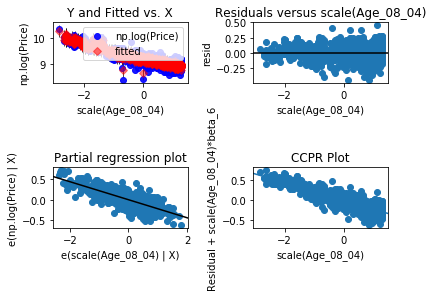

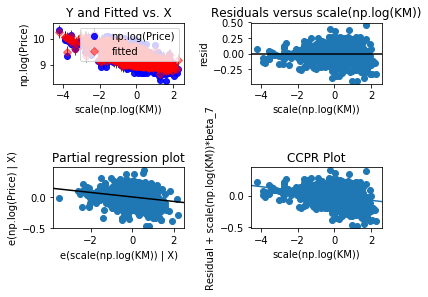

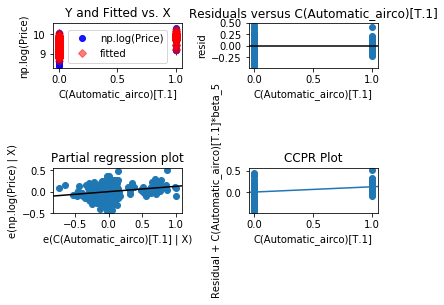

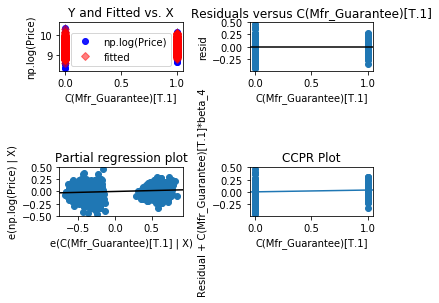

In [595]:
# model 6에서 선택된 독립변수들에 대한 partial regression plot

fig = sm.graphics.plot_regress_exog(result_3, 'scale(Age_08_04)')
fig.suptitle("")
#plt.show()

fig = sm.graphics.plot_regress_exog(result_3, 'scale(np.log(KM))')
fig.suptitle("")
#plt.show()

fig = sm.graphics.plot_regress_exog(result_3, 'C(Automatic_airco)[T.1]')
fig.suptitle("")
#plt.show()

fig = sm.graphics.plot_regress_exog(result_3, 'C(Mfr_Guarantee)[T.1]')
fig.suptitle("")
plt.show()